In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

np.random.seed(42)
torch.manual_seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
class_names = ['a', 'b', 'c']
train_dir = 'data/train'
val_dir = 'data/val'

In [3]:
# check file extensension, and sizes
train_ext = set()
val_ext = set()

for class_name in class_names:
    folder_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(folder_path)]
    train_ext.update([os.path.splitext(f)[1] for f in image_files])
    folder_path = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(folder_path)]
    val_ext.update([os.path.splitext(f)[1] for f in image_files])
print('Train extensions:', train_ext)
print('Val extensions:', val_ext)

Train extensions: {'', '.jpg', '.png', '.bmp'}
Val extensions: {'.jpg', '.png', '.bmp'}


In [4]:
# the empty ext name in train_ext is probably from .DS_Store
# we can treat the rest of the extensions as 'valid externsions' to surpass any filetype errors.
val_ext.update(train_ext)
valid_extensions = [e for e in val_ext if e != '']
valid_extensions

['.png', '.bmp', '.jpg']

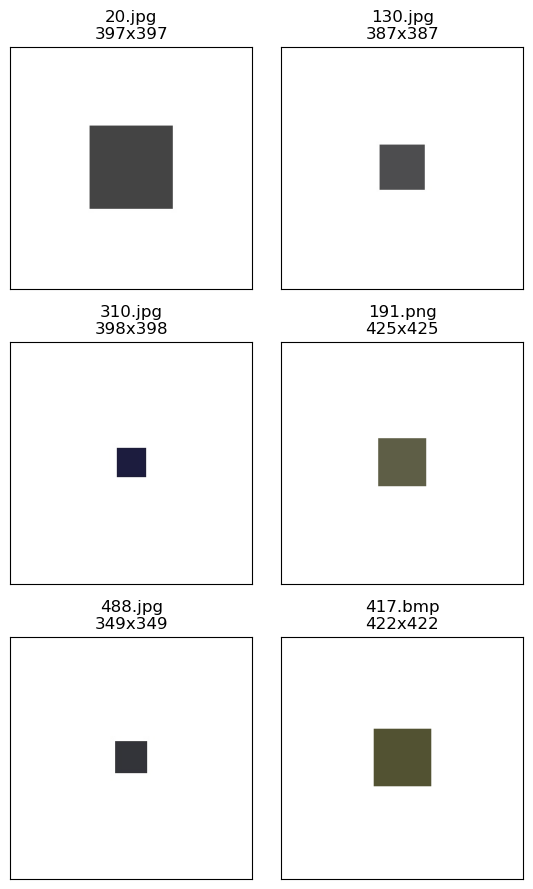

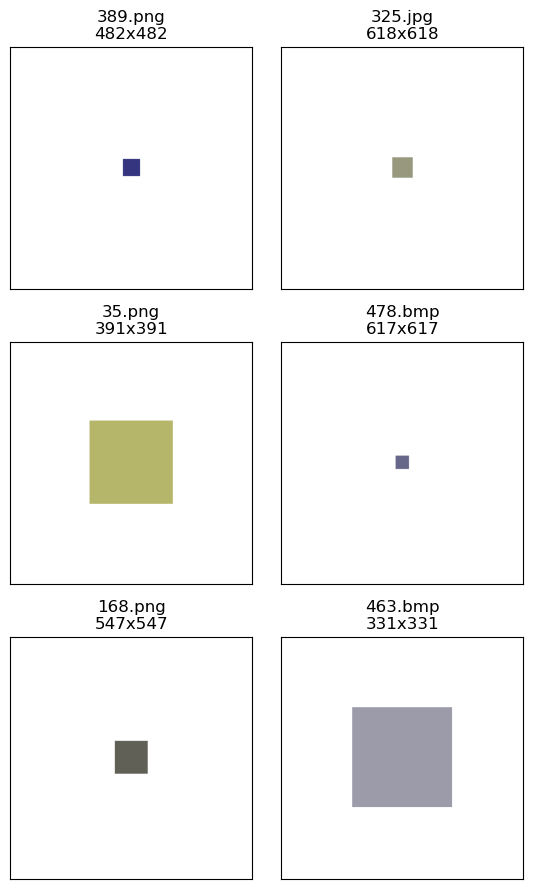

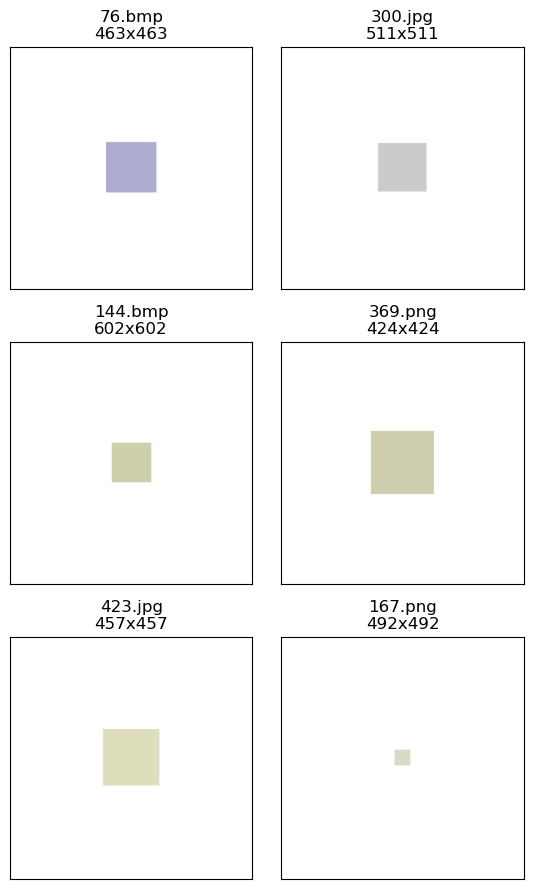

In [5]:
num_samples_col = 2
num_samples_row = 3

for class_name in class_names:
    folder_path = os.path.join('data', 'train', class_name)
    image_files = [f for f in os.listdir(folder_path) if any(f.endswith(ext) for ext in valid_extensions)]
    selected_images = random.sample(image_files, num_samples_row * num_samples_col)
    plt.figure(figsize=(3 * num_samples_col, 3 * num_samples_row))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot( num_samples_row, num_samples_col, i+1)
        plt.imshow(np.array(img))
        width, height = img.size
        plt.tight_layout()
        plt.title(f"{os.path.basename(img_file)}\n{width}x{height}")
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

right of the bat, it seems obvious that there is an easy semanitc difference between the 3 classes. 
class a looks darker than the rest, 
class b looks more saturated,
class c looks lighter in color.

before testing the vision models, I'll create a classification based on rgba values of the cenetr pixel from these images. There is a mix of different image file types, so we may have to do some work with color values to make them uniform

Looks like all the color values are the same format 

In [6]:
len([x for x in [img.getpixel((width//2, i)) for i in range(height)] if x!=(255, 255, 255)])

32

In [7]:
train_df = pd.DataFrame(columns=['class', 'filename', 'width', 'height', 'r', 'g', 'b', 'inner_width'])
for class_name in ['a', 'b', 'c']:
    folder_path = os.path.join('data', 'train', class_name)
    image_files = [f for f in os.listdir(folder_path) if any(f.endswith(ext) for ext in valid_extensions)]
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        width, height = img.size
        r, g, b = [x/255 for x in img.getpixel((width//2, height//2))]
        inner_width = len([x for x in [img.getpixel((width//2, i)) for i in range(height)] if x!=(255, 255, 255)])
        row = {
            'class': class_name,
            'filename': img_file,
            'width': width,
            'height': height,
            'r': r, 
            'g': g,
            'b': b,
            'inner_width': inner_width
        }
        train_df.loc[len(train_df)] = row

train_df.to_csv('data/train.csv', index=False)

In [8]:
val_df = pd.DataFrame(columns=['class', 'filename', 'width', 'height', 'r', 'g', 'b', 'inner_width'])
for class_name in ['a', 'b', 'c']:
    folder_path = os.path.join('data', 'val', class_name)
    image_files = [f for f in os.listdir(folder_path) if any(f.endswith(ext) for ext in valid_extensions)]
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        width, height = img.size
        r, g, b = [x/255 for x in img.getpixel((width//2, height//2))]
        inner_width = len([x for x in [img.getpixel((width//2, i)) for i in range(height)] if x!=(255, 255, 255)])
        row = {
            'class': class_name,
            'filename': img_file,
            'width': width,
            'height': height,
            'r': r, 
            'g': g,
            'b': b,
            'inner_width': inner_width
        }
        val_df.loc[len(val_df)] = row

val_df.to_csv('data/val.csv', index=False)

In [9]:
colors = {}
for c in class_names:
    colors[c] = train_df[train_df['class'] == c].sample()[['r', 'g', 'b']].values[0]

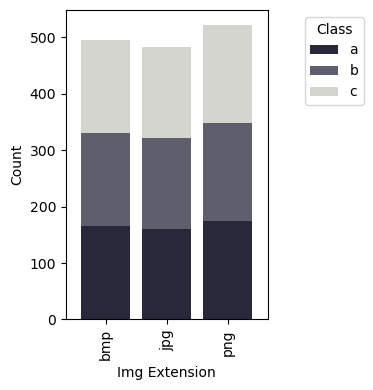

In [10]:
# stacked bar chart to show extensions 
plt.figure(figsize=(4, 4))

train_df['extensions'] = train_df['filename'].apply(lambda x: x.split('.')[1])
ext_counts_per_class = train_df[['class', 'extensions']].groupby(['class', 'extensions']).value_counts().reset_index()
pivoted_data = ext_counts_per_class.pivot(index='extensions', columns='class', values='count')

pivoted_data.plot(kind='bar', 
                  stacked=True, 
                  ax=plt.gca(), 
                  color=[colors[c] for c in class_names], 
                  legend=True, width=0.8)

plt.xlabel('Img Extension')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper left', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [11]:
# plt.figure(figsize=(6, 4))
# size_by_class = train_df[['class', 
#                           'width']].groupby(['class', 
#                                              'width']).value_counts().reset_index()

# g = sns.histplot(
#     data=size_by_class,
#     x='width',
#     hue='class',
#     multiple='stack',
#     bins=20,
#     palette=colors,
#     hue_order=class_names[::-1],
#     stat='count',
#     legend=True, 
#     alpha=1,
#     edgecolor='white',
# )

# l = g.get_legend()
# l.set_bbox_to_anchor((1.05, 1))
# l.set_title('Class')

# plt.xlabel('image width (px)')
# plt.ylabel('Count')
# plt.tight_layout()
# plt.show()

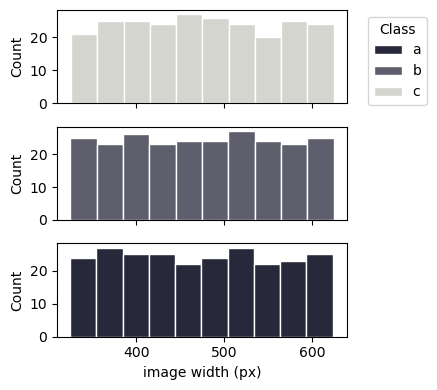

In [12]:
fig, axs = plt.subplots( nrows = 3, ncols = 1, figsize=(4.5, 4), sharex=True)

size_by_class = train_df[['class', 
                    'width']].groupby(['class', 
                                        'width']).value_counts().reset_index()

for i, c in enumerate(class_names[::-1]):
    g = sns.histplot(
        data=size_by_class[size_by_class['class'] == c],
        x='width',
        hue='class',
        multiple='stack',
        bins=10,
        palette=colors,
        hue_order=class_names,
        stat='count',
        alpha=1,
        edgecolor='white',
        ax = axs[i]
    )
    if i == 0:
        l = g.get_legend()
        l.set_bbox_to_anchor((1.05, 1))
        l.set_title('Class')
    else:
        g.get_legend().remove()

plt.xlabel('image width (px)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

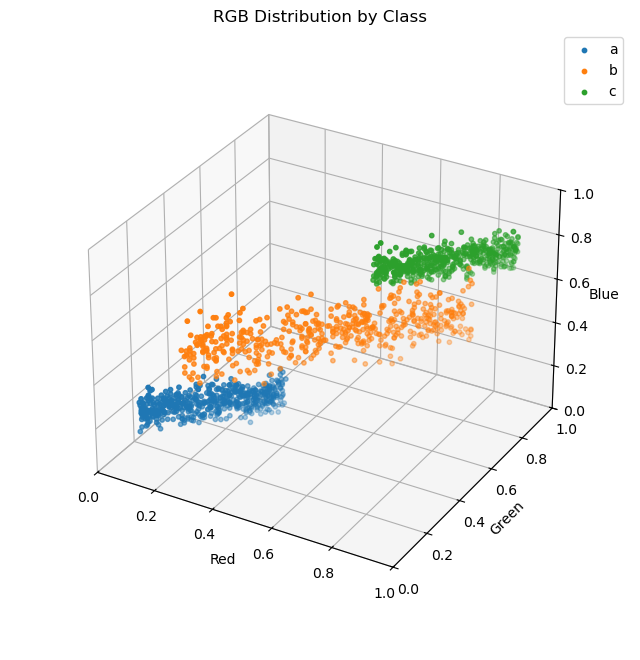

In [13]:
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d', )

n = 500
# plot_df = train_df.sample(n)

for c in class_names:
    plot_df = train_df[train_df['class'] == c]
    ax.scatter(plot_df['r'], 
               plot_df['g'], 
               plot_df['b'], 
               marker= 'o', 
               label=c, 
               s = 10)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('RGB Distribution by Class')
ax.set_box_aspect(None, zoom=0.85)
ax.legend()
plt.show()

In [14]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                if any(img_name.endswith(ext) for ext in valid_extensions):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.samples.append((img_path, self.class_to_idx[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

combined_metrics = pd.DataFrame(columns=['model_name', 'class', 'accuracy', 'precision', 'recall', 'f1'])


# Basic model
class basicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # Just 8 filters
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(8 * 16 * 16, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    

def eval_torch_model(model, dataset, device = 'cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    if dataset == 'train':
        data_loader = train_loader
    else:
        data_loader = val_loader

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmax = 500, 
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Truth labels')
    plt.title(f'{dataset} data')
    plt.tight_layout()
    plt.show()

    return cm

Epoch 1, Accuracy: 50.53%
Epoch 2, Accuracy: 64.27%
Epoch 3, Accuracy: 59.93%
Epoch 4, Accuracy: 61.47%
Epoch 5, Accuracy: 72.20%
Epoch 6, Accuracy: 69.20%
Epoch 7, Accuracy: 75.67%
Epoch 8, Accuracy: 79.40%
Epoch 9, Accuracy: 80.47%
Epoch 10, Accuracy: 84.13%


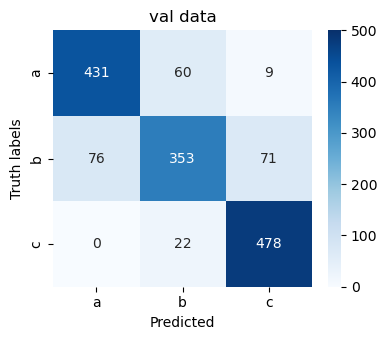

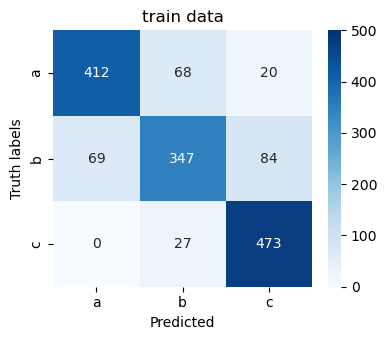

In [15]:
num_epochs = 10

transform = transforms.Compose([transforms.Resize((32, 32)), 
                                transforms.ToTensor()])

train_dataset = ImageDataset(train_dir, transform)
val_dataset = ImageDataset(val_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cpu")
first_cnn_model = basicCNN(len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(first_cnn_model.parameters(), lr=0.001)

# Train
for epoch in range(num_epochs):
    first_cnn_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = first_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Quick validation
    first_cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = first_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

torch.save(first_cnn_model.state_dict(), 'img_classifier.pth')

# evaluation
val_cm = eval_torch_model(first_cnn_model, 'val', device)
train_cm = eval_torch_model(first_cnn_model, 'train', device)

In [16]:
for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'basicCNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

Class a:
  Precision: 0.85
  Recall: 0.86
  F1 Score: 0.86
Class b:
  Precision: 0.81
  Recall: 0.71
  F1 Score: 0.76
Class c:
  Precision: 0.86
  Recall: 0.96
  F1 Score: 0.90


In [17]:
# second try
class secondCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.classifier(x)
        return x

Epoch 1, Accuracy: 95.13%
Epoch 2, Accuracy: 97.73%
Epoch 3, Accuracy: 93.93%
Epoch 4, Accuracy: 98.20%
Epoch 5, Accuracy: 97.40%
Epoch 6, Accuracy: 97.33%
Epoch 7, Accuracy: 98.27%
Epoch 8, Accuracy: 98.40%
Epoch 9, Accuracy: 98.33%
Epoch 10, Accuracy: 98.33%


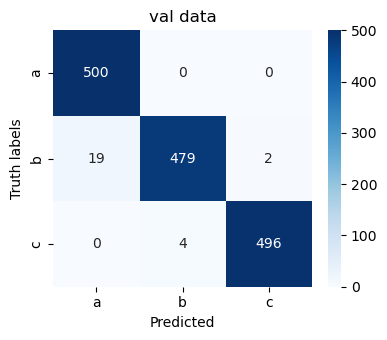

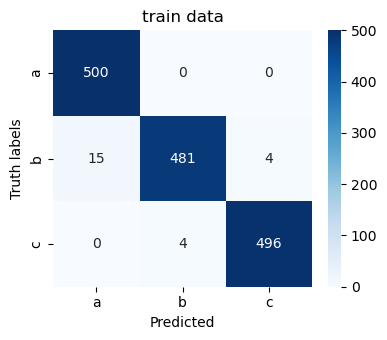

In [18]:
num_epochs = 10

transform = transforms.Compose([transforms.CenterCrop((32)), 
                                transforms.ToTensor()])
train_dataset = ImageDataset(train_dir, transform)
val_dataset = ImageDataset(val_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cpu")
second_cnn_model = secondCNN(len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(second_cnn_model.parameters(), lr=0.001)

# Train
for epoch in range(num_epochs):
    second_cnn_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = second_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Quick validation
    second_cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = second_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

torch.save(second_cnn_model.state_dict(), 'img_classifier_center_crop.pth')

# evaluation
val_cm = eval_torch_model(second_cnn_model, 'val', device)
train_cm = eval_torch_model(second_cnn_model, 'train', device)

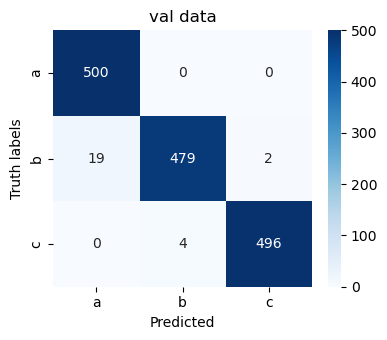

Class a:
  Precision: 0.96
  Recall: 1.00
  F1 Score: 0.98
Class b:
  Precision: 0.99
  Recall: 0.96
  F1 Score: 0.97
Class c:
  Precision: 1.00
  Recall: 0.99
  F1 Score: 0.99


In [19]:
val_cm = eval_torch_model(second_cnn_model, 'val', device)

for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'secondCNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

Accuracy: 98.40%


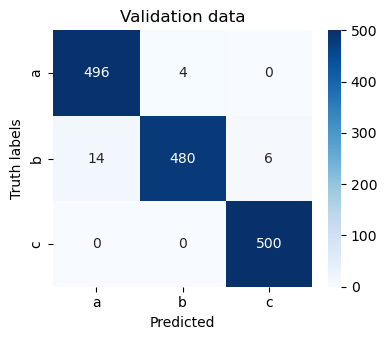

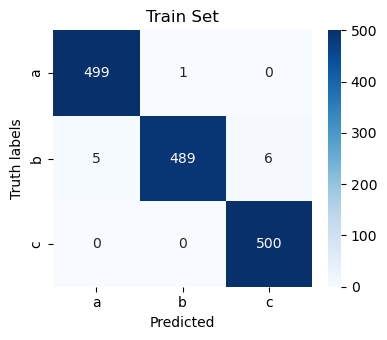

In [20]:
X_train = train_df[['r', 'g', 'b']].values  # Using raw RGB values
y_train = train_df['class'].values

X_val = val_df[['r', 'g', 'b']].values
y_val = val_df['class'].values

X_train_scaled = X_train
X_val_scaled = X_val

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {100 * accuracy:.2f}%")

classes = np.unique(y_train)
val_cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(4, 3.5))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Truth labels')
plt.title('Validation data')
plt.tight_layout()
plt.show()


train_cm = confusion_matrix(y_train, knn.predict(X_train_scaled))
plt.figure(figsize=(4, 3.5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Truth labels')
plt.title('Train Set')
plt.tight_layout()
plt.show()

In [21]:
for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'KNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

Class a:
  Precision: 0.97
  Recall: 0.99
  F1 Score: 0.98
Class b:
  Precision: 0.99
  Recall: 0.96
  F1 Score: 0.98
Class c:
  Precision: 0.99
  Recall: 1.00
  F1 Score: 0.99


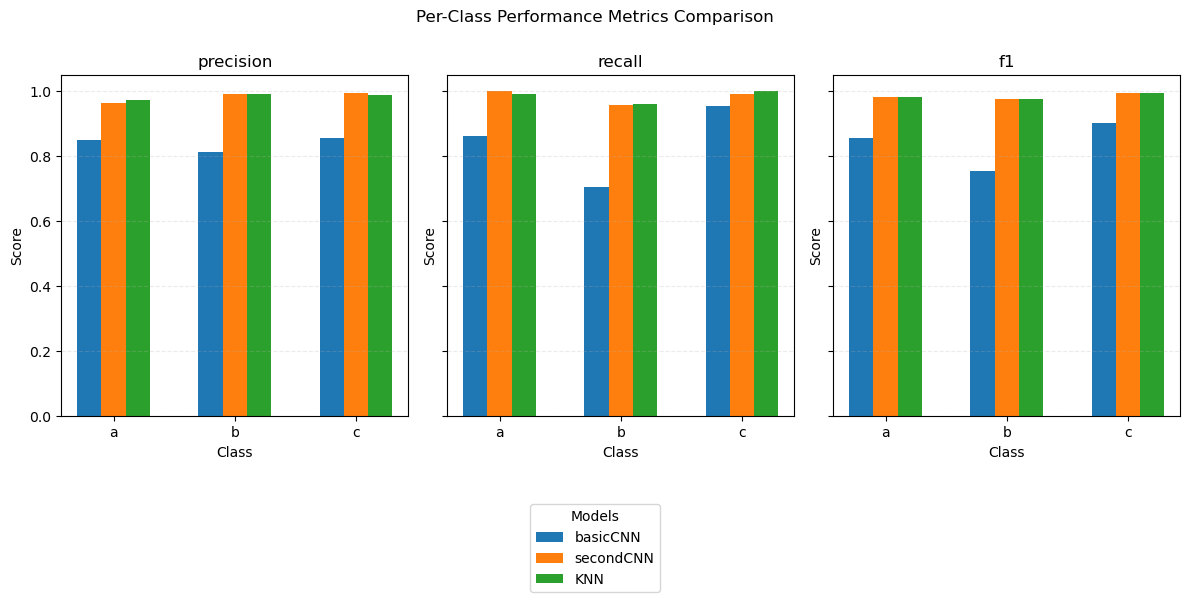

In [22]:
num_classes = combined_metrics['class'].nunique()
num_models = combined_metrics['model_name'].nunique()
metrics = ['precision', 'recall', 'f1']

x = np.arange(num_classes)
bar_width = 0.20

fig, axes = plt.subplots(1, num_models, figsize=(12, 5), sharey=True)
fig.suptitle('Per-Class Performance Metrics Comparison')

for i in range(len(metrics)):
    ax = axes[i]
    metric_name = metrics[i]

    for j, model in enumerate(combined_metrics['model_name'].unique()):
        model_name = combined_metrics['model_name'].unique()[j]
        positions = x + (j - (num_models - 1) / 2) * bar_width
        scores = combined_metrics[combined_metrics['model_name'] == model_name][metric_name]
        rects = ax.bar(positions, scores, bar_width, label=model_name if i == 0 else "")

    ax.set_ylabel('Score')
    ax.set_xlabel('Class')
    ax.set_title(metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(classes) 
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
  


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005), ncol=1, title="Models")

plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()